In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_default_device",jax.devices()[0])
from jax import jit,jacrev
import numpy as np
import matplotlib.pyplot as plt
import jax
from tqdm.auto import tqdm
plt.style.use("ggplot")

from importlib import reload
import KernelTools
reload(KernelTools)
from KernelTools import *
from EquationModel import InducedRKHS,OperatorModel,CholOperatorModel
from parabolic_data_utils import (
    build_burgers_data,build_tx_grid,
    build_tx_grid_chebyshev,setup_problem_data,build_burgers_data_periodic
)
from plotting import plot_input_data,plot_compare_error
from evaluation_metrics import compute_results    


/home/owlx/miniconda3/envs/alex_keql/lib/python3.12/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csc_array is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


  0%|          | 0/10099 [00:00<?, ?it/s]

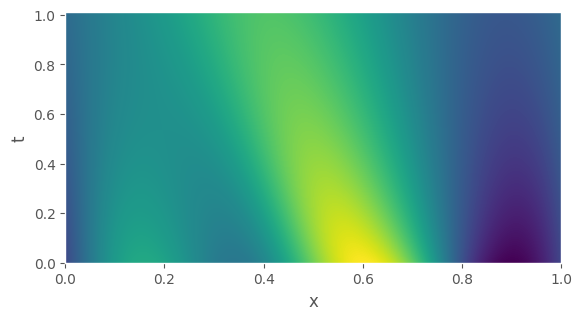

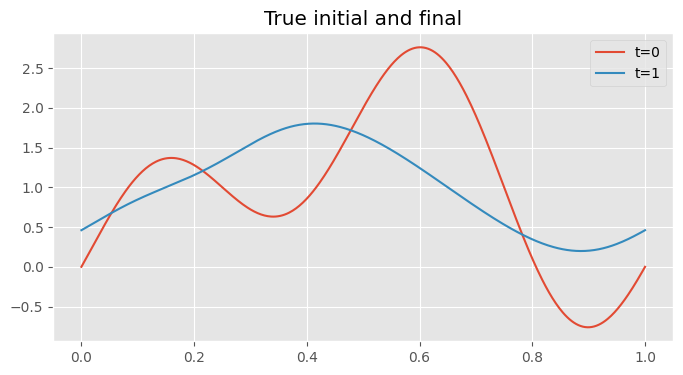

In [2]:
def func_u0(x):
    u0 = (1 + np.sin(4 * np.pi*x) - np.cos(2*np.pi*x))
    return u0


kappa = 1e-2
alpha = 0.1


u_true_function,ut_true_function,interpolant,t_vals,sols = (
    build_burgers_data_periodic(func_u0=func_u0,kappa = kappa,alpha = alpha,k_timestep=0.0001,n_finite_diff=1999)
)

plt.imshow(sols[::-1],aspect = 0.5,extent = [0,1,t_vals[0],t_vals[-1]])
plt.xlabel("x")
plt.ylabel("t")
plt.grid(None)
plt.show()
plt.figure(figsize=(8,4))
num_fine_grid = 500
plt.title("True initial and final")
grid_points = jnp.linspace(0,1,num_fine_grid)
plt.plot(grid_points,u_true_function(jnp.vstack([0.0*jnp.ones(num_fine_grid),grid_points]).T),label = 't=0')
plt.plot(grid_points,u_true_function(jnp.vstack([1.*jnp.ones(num_fine_grid),grid_points]).T),label = 't=1')
plt.legend()
plt.show()

In [3]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid([0,1],[-1/(num_grid_x-2),1],num_grid_t,num_grid_x)
tx_int

num_points = 40


tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy[:0],
    num_points,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)


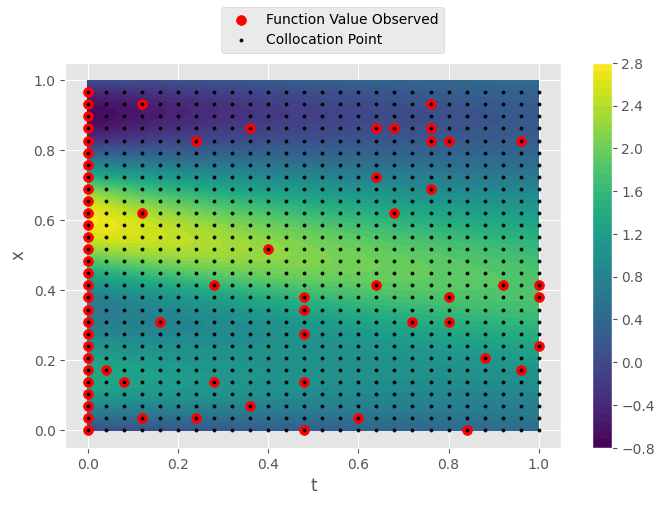

In [4]:
num_grid_x = 31
num_grid_t = 26
tx_int,tx_bdy = build_tx_grid([0,1],[-1/(num_grid_x-2),1],num_grid_t,num_grid_x)
tx_int

num_points = 40


tx_all,tx_obs = setup_problem_data(
    tx_int,
    tx_bdy[:0],
    num_points,
    jax.random.PRNGKey(55),
    times_to_observe = (0,)
)

u_true = u_true_function(tx_all)
u_obs = u_true_function(tx_obs)

num_fine_grid = 300
initial_time = 0
final_time = 1
t_fine,x_fine = jnp.meshgrid(jnp.linspace(initial_time,final_time,num_fine_grid),jnp.linspace(0,1,num_fine_grid))
tx_fine = jnp.vstack([t_fine.flatten(),x_fine.flatten()]).T
plot_input_data(
    tx_obs,
    tx_all,
    u_true_function,
    tx_fine,
)

In [5]:
from optimistix import NonlinearCG,minimise

def fit_kernel_params(parametrized_kernel,X,y,init_params,nugget = 1e-7,**kwargs):
    def marginal_like(params,args=None):
        vmapped_kfunc = vectorize_kfunc(partial(parametrized_kernel,params = params))
        K = vmapped_kfunc(X,X)
        K = K + nugget * diagpart(K)
        return (1/2) * y.T@jnp.linalg.inv(K)@y + (1/2) * jnp.linalg.slogdet(K).logabsdet

    solution = minimise(marginal_like,NonlinearCG(1e-5,1e-5),init_params)
    optimized_params = solution.value

    final_val = marginal_like(optimized_params)

    return optimized_params,solution#,partial(parametrized_kernel,params = optimized_params)

In [6]:
from Kernels import (
    get_centered_scaled_poly_kernel,
    get_anisotropic_gaussianRBF,
    get_gaussianRBF
)
from EquationModel import CholInducedRKHS, CholOperatorModel, OperatorPDEModel
from functools import partial

u_operators = (eval_k,)#(eval_k,dx_k,dt_k,dxx_k)
feature_operators = (eval_k,dx_k,dxx_k)

from Kernels import log1pexp,inv_log1pexp

def periodic_transform(x,period = 1.):
    return jnp.hstack([jnp.sin(x*(2*jnp.pi/period)),jnp.cos(x*(2*jnp.pi/period))])/(period * 2*jnp.pi)

def param_ani_periodic_GRBF(x,y,params):
    lengthscales = log1pexp(params)
    return get_gaussianRBF(lengthscales[0])(x[0],y[0]) * get_gaussianRBF(lengthscales[1])(periodic_transform(x[1]),periodic_transform(y[1]))

# fitted_params,opt_result = fit_kernel_params(param_ani_periodic_GRBF,tx_obs,u_obs,jnp.zeros(2))
# ML_lengthscales = log1pexp(fitted_params)
# print("Fitted lengthscales ",ML_lengthscales)

manual_lengthscales = jnp.array([0.25,0.2])
fitted_params = inv_log1pexp(manual_lengthscales)
print(f"Using manual lengthscales: {manual_lengthscales}")

k_u = partial(param_ani_periodic_GRBF,params = fitted_params)

u_model = CholInducedRKHS(
    tx_all,
    u_operators,
    k_u,
    nugget_size = 1e-10
    )

u_params_init = u_model.get_fitted_params(tx_obs,u_obs)

grid_features_init = (
    (u_model.evaluate_operators(feature_operators,tx_int,u_params_init))
    .reshape(
            len(tx_int),
            len(feature_operators),
            order = 'F'
        )
)

k_P_u_part = get_centered_scaled_poly_kernel(2,grid_features_init,c=1.,scaling = 'diagonal')

@vectorize_kfunc
def k_P(x,y):
    return k_P_u_part(x[2:],y[2:])

P_model = OperatorModel(k_P)    
    

EqnModel = OperatorPDEModel(
    P_model,
    (u_model,),
    (tx_obs,),
    (u_obs,),
    (tx_int,),
    feature_operators,
    rhs_operator=dt_k,
    datafit_weight = 100
)

#plt.tricontourf(tx_int[:,0],tx_int[:,1],vectorize_kfunc(k_u)(jnp.array([[0.5,0.9]]),tx_int)[0])

Using manual lengthscales: [0.25 0.2 ]


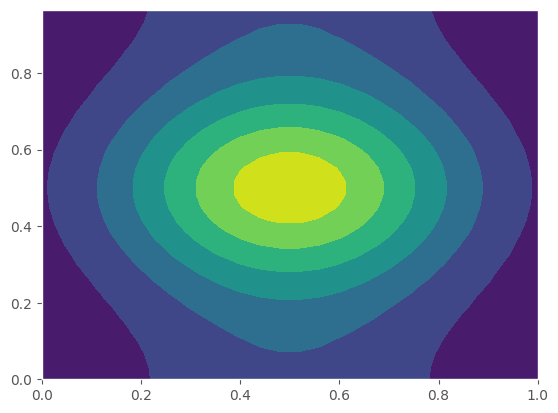

In [7]:
k_u = partial(param_ani_periodic_GRBF,params = fitted_params)
plt.tricontourf(tx_int[:,0],tx_int[:,1],vectorize_kfunc(k_u)(jnp.array([[0.5,0.5]]),tx_int)[0])

  0%|          | 0/501 [00:00<?, ?it/s]

Iteration 0, loss = 0.05564, Jres = 73.4, alpha = 0.08333, improvement_ratio = 1.014
Iteration 1, loss = 0.03492, Jres = 2.368, alpha = 0.06944, improvement_ratio = 1.012
Iteration 2, loss = 0.02525, Jres = 0.3365, alpha = 0.05787, improvement_ratio = 1.004
Iteration 3, loss = 0.01923, Jres = 0.1318, alpha = 0.04823, improvement_ratio = 1.002
Iteration 4, loss = 0.01513, Jres = 0.1261, alpha = 0.04019, improvement_ratio = 1.002
Iteration 5, loss = 0.01217, Jres = 0.1361, alpha = 0.03349, improvement_ratio = 1.001
Iteration 100, loss = 1.277e-05, Jres = 5.813e-06, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 200, loss = 7.965e-06, Jres = 8.45e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 300, loss = 6.548e-06, Jres = 3.099e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 400, loss = 5.699e-06, Jres = 1.857e-07, alpha = 8.333e-07, improvement_ratio = 1.0
Iteration 500, loss = 5.122e-06, Jres = 1.614e-07, alpha = 8.333e-07, improvement_ratio = 1.0


  0%|          | 0/500 [00:00<?, ?it/s]

Iteration 0, loss = 5.095521483400465e-06
Iteration 50, loss = 1.9644326139606893e-06
Iteration 98 Step Failed
Iteration 99 Step Failed
Iteration 100, loss = 1.0009888093872572e-07
Iteration 101 Step Failed
Iteration 102 Step Failed
Iteration 103 Step Failed
Iteration 104 Step Failed
Iteration 105 Step Failed
Iteration 106 Step Failed
Iteration 107 Step Failed
Iteration 108 Step Failed
Iteration 109 Step Failed
Iteration 110 Step Failed
Converged by no improvement


/tmp/ipykernel_2228453/3403536192.py:24: DeprecationWarning: hstack requires ndarray or scalar arguments, got <class 'list'> at position 0. In a future JAX release this will be an error.
  plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))


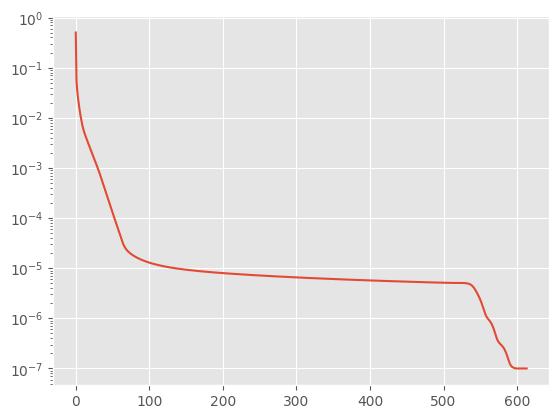

In [8]:
import Optimizers
import importlib
importlib.reload(Optimizers)
from Optimizers import CholeskyLM,SVD_LM

params_init = jnp.hstack([u_params_init,jnp.zeros(len(grid_features_init))])

params,convergence_data = CholeskyLM(
    params_init.copy(),
    EqnModel,
    beta = 1e-11,
    max_iter = 501,
    init_alpha=0.1,
    line_search_increase_ratio=1.4,
    print_every = 100
)

p_adjusted,refine_convergence_data = SVD_LM(
    params,EqnModel,initial_reg = 1e-3,num_iter = 500,
    overall_regularization=1e-16,
    print_every = 50,
    mult = 0.75
    )
plt.plot(jnp.hstack([convergence_data['loss_vals'],refine_convergence_data['loss_vals']]))
plt.yscale('log')
plt.show()

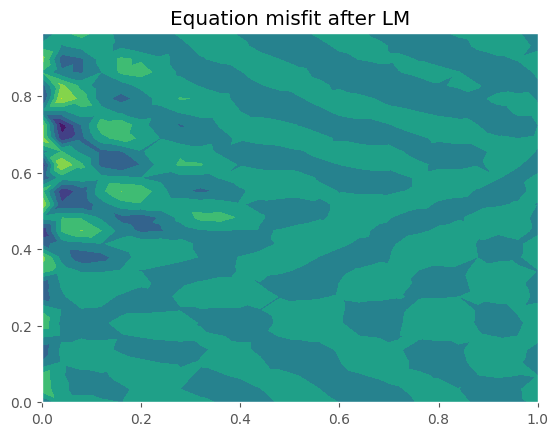

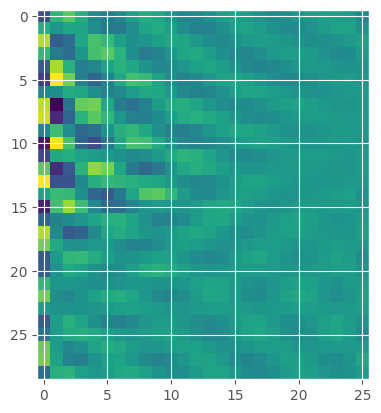

Pre Refinement PDE MSE 9.850072233517233e-06
Post Refinement PDE MSE 1.5514051455819628e-07


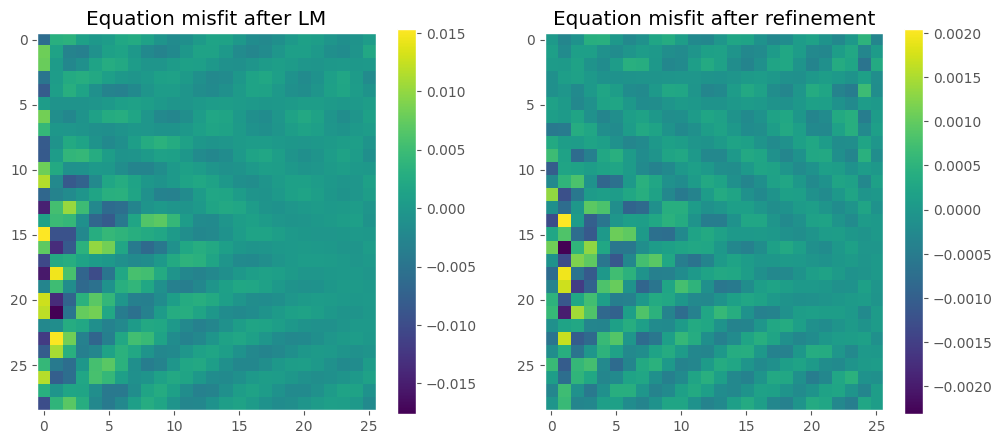

In [9]:
equation_residuals = EqnModel.equation_residual(params)
equation_residuals_refined = EqnModel.equation_residual(p_adjusted)
plt.title("Equation misfit after LM")
plt.tricontourf(tx_int[:,0],tx_int[:,1],equation_residuals)
plt.show()
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t)[::-1])
plt.show()

print("Pre Refinement PDE MSE",jnp.mean(equation_residuals**2))
print("Post Refinement PDE MSE",jnp.mean(equation_residuals_refined**2))
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.title("Equation misfit after LM")
plt.imshow(equation_residuals.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()

plt.subplot(1,2,2)
plt.title("Equation misfit after refinement")
plt.imshow(equation_residuals_refined.reshape(num_grid_x-2,num_grid_t))
plt.grid(None)
plt.colorbar()
plt.show()


,NRMSE,NMAE
1 Step,0.000010,0.000008
2 Step,0.038509,0.024055


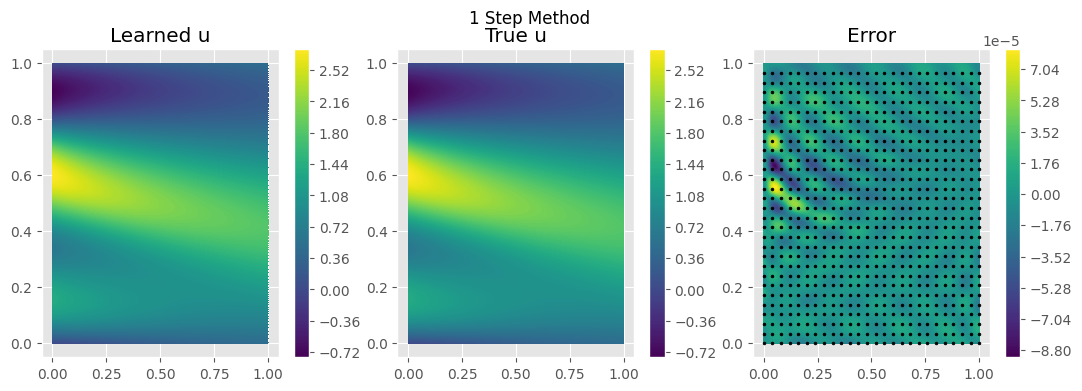

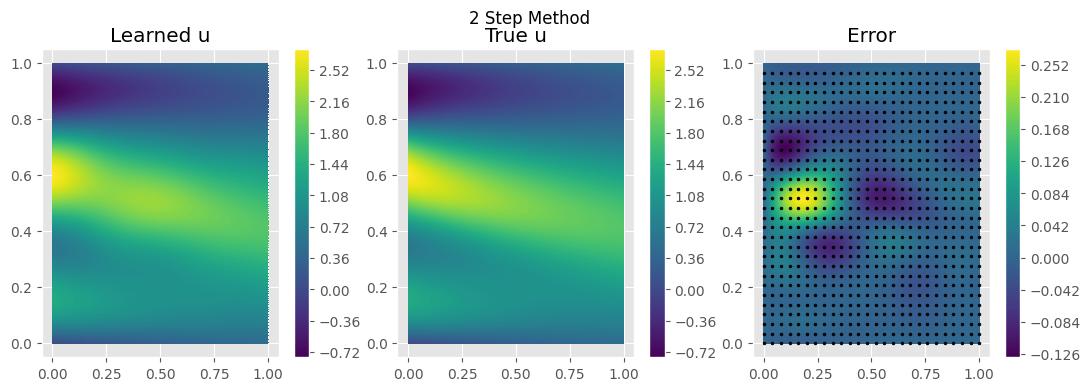

In [10]:
from evaluation_metrics import get_nrmse,get_nmae,compute_results

u_sol = p_adjusted[:u_model.num_params]
P_sol = p_adjusted[u_model.num_params:]


num_fine_grid = 200
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid),np.linspace(0,1,num_fine_grid))
tx_grid_fine = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


u_eval_fine =u_model.point_evaluate(tx_grid_fine,u_sol)
u_true_fine = u_true_function(tx_grid_fine)

display(compute_results(
    u_true_fine,
    {
        "1 Step":u_eval_fine,
        "2 Step":u_model.point_evaluate(tx_grid_fine,u_params_init),
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
))

plot_compare_error(
    tx_grid_fine,tx_all,None,lambda x:u_model.point_evaluate(x,u_sol),u_true_function,title= "1 Step Method"
)

plot_compare_error(
    tx_grid_fine,tx_all,None,lambda x:u_model.point_evaluate(x,u_params_init),u_true_function,title = "2 Step Method"
)

In [11]:
num_fine_grid = 100
t_fine,x_fine = np.meshgrid(np.linspace(0,final_time,num_fine_grid+4)[2:-2],np.linspace(0,1,num_fine_grid+4)[2:-2])
tx_fine_int = np.vstack([t_fine.flatten(),x_fine.flatten()]).T


# grad_u_true = jax.vmap(grad(u_single))(tx_fine_int)
# hess_u_true = jax.vmap(hessian(u_single))(tx_fine_int)

u_true_interior = u_true_function(tx_fine_int)
ut_true = interpolant.partial_derivative(1,0)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
ux_true = interpolant.partial_derivative(0,1)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)
uxx_true = interpolant.partial_derivative(0,2)(tx_fine_int[:,0],tx_fine_int[:,1],grid = False)


true_features = jnp.vstack([u_true_interior,ux_true,uxx_true]).T
true_features = jnp.hstack([tx_fine_int,true_features])

model_grid_features = EqnModel.get_stacked_eqn_features((u_sol,))
model_features = EqnModel.get_single_eqn_features(u_model,u_sol,tx_fine_int)
#model_features = u_model.evaluate_operators(feature_operators,tx_fine_int,u_sol).reshape(len(tx_fine_int),len(feature_operators),order = 'F')

preds_ut_model_features = P_model.kernel_function(model_features,model_grid_features)@P_sol
preds_ut_true_features = P_model.kernel_function(true_features,model_grid_features)@P_sol

init_P_features = EqnModel.get_stacked_eqn_features((u_params_init,))

K = P_model.kernel_function(init_P_features,init_P_features)

P_params_naive = jnp.linalg.solve(K+1e-8*diagpart(K),EqnModel.get_stacked_rhs_op((u_params_init,)))

init_P_features_fine = EqnModel.get_single_eqn_features(u_model,u_params_init,tx_fine_int)
P_preds_init_model_features_init = P_model.kernel_function(init_P_features_fine,init_P_features)@P_params_naive

P_preds_init_model_features = P_model.kernel_function(model_features,init_P_features)@P_params_naive
P_preds_init_true_features = P_model.kernel_function(true_features,init_P_features)@P_params_naive

compute_results(
    ut_true,
    {
        "1 Step Model Features":preds_ut_model_features,
        "1 Step True Features":preds_ut_true_features,
        "2 Step Model Features": P_preds_init_model_features_init,
        "2 Step True Features":P_preds_init_true_features,
    },
    {"NRMSE":get_nrmse,"NMAE":get_nmae}
)

,NRMSE,NMAE
1 Step Model Features,0.000268,0.000222
1 Step True Features,0.000037,0.000031
2 Step Model Features,0.175564,0.133154
2 Step True Features,0.069479,0.057699


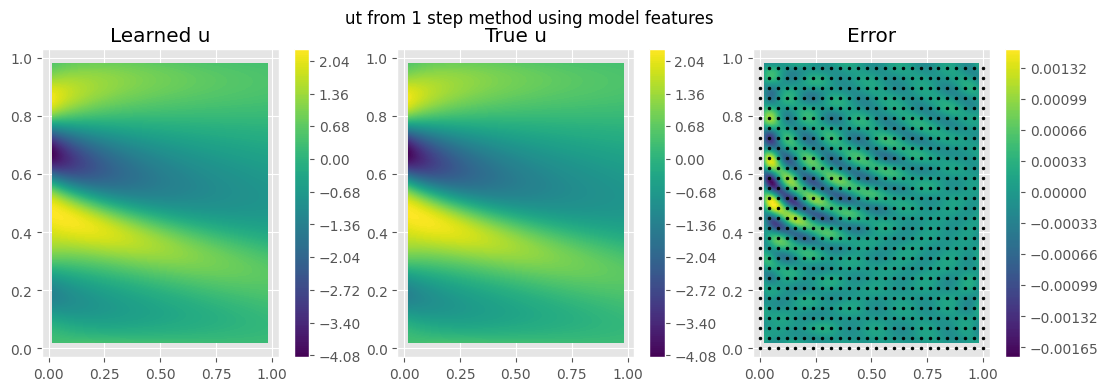

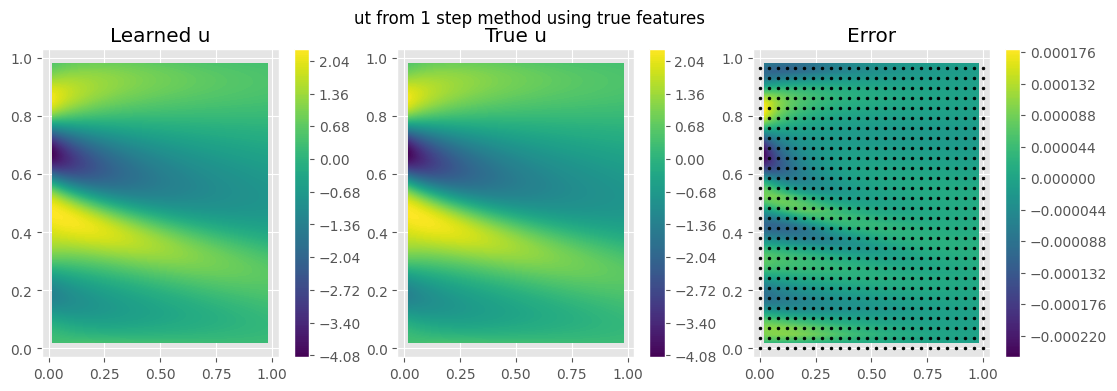

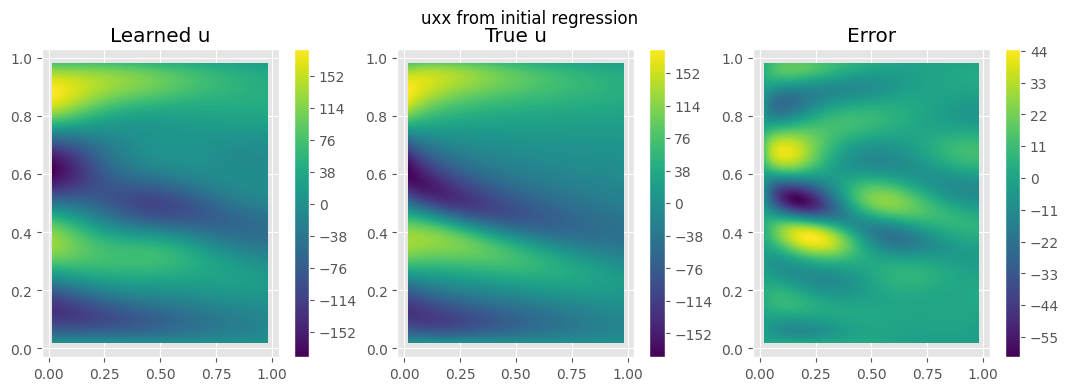

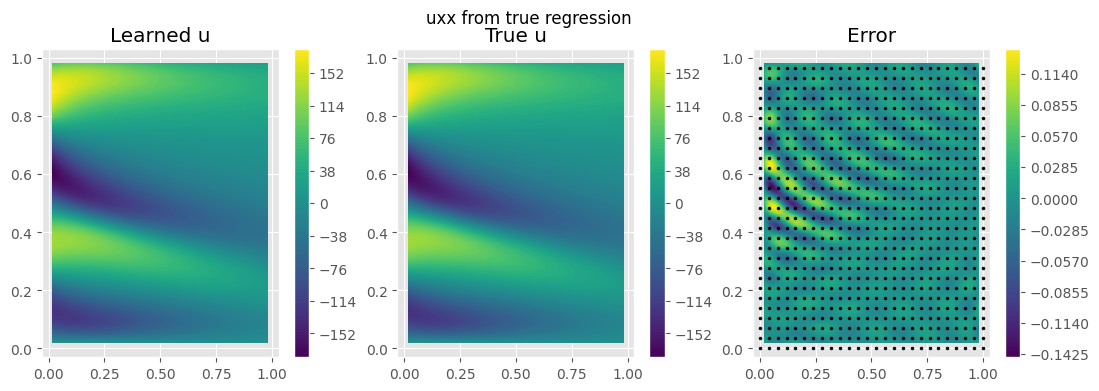

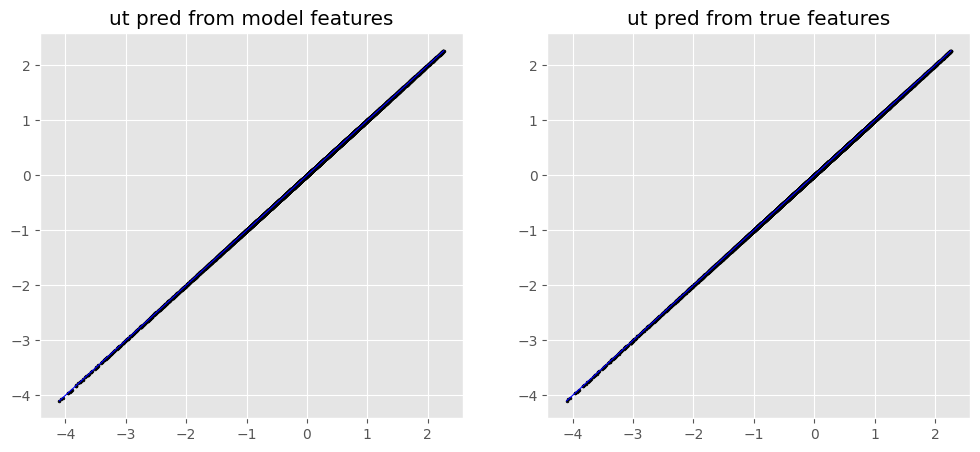

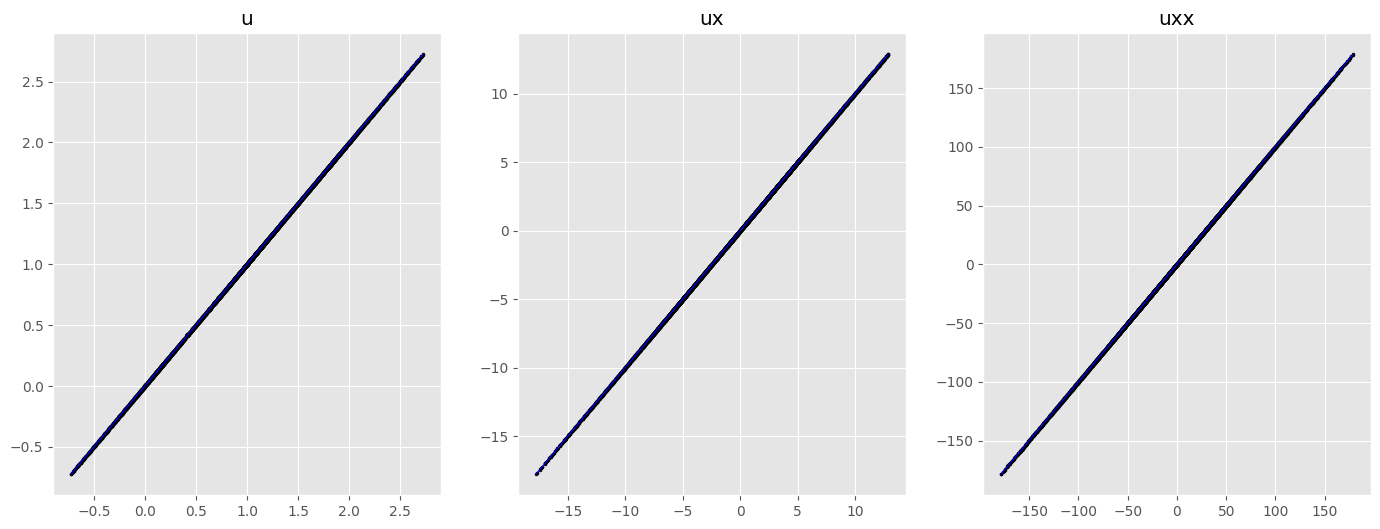

In [12]:
from plotting import compare_values,plot_compare_error_values

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_model_features,ut_true,title = "ut from 1 step method using model features"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,preds_ut_true_features,ut_true,title = "ut from 1 step method using true features"
)

plot_compare_error_values(
    tx_fine_int,None,None,init_P_features_fine[:,4],uxx_true,title = "uxx from initial regression"
)

plot_compare_error_values(
    tx_fine_int,tx_all,None,model_features[:,4],uxx_true,title = "uxx from true regression"
)

plt.figure(figsize = (12,5))
plt.subplot(1,2,1)
plt.title('ut pred from model features')
compare_values(preds_ut_model_features,ut_true)
plt.subplot(1,2,2)
plt.title('ut pred from true features')
compare_values(preds_ut_true_features,ut_true)
plt.show()

plt.figure(figsize= (17,6))
plt.subplot(1,3,1)
plt.title('u')
compare_values(model_features[:,2],true_features[:,2])
plt.subplot(1,3,2)
plt.title('ux')
compare_values(model_features[:,3],true_features[:,3])
plt.subplot(1,3,3)
plt.title("uxx")
compare_values(model_features[:,4],true_features[:,4])
plt.show()


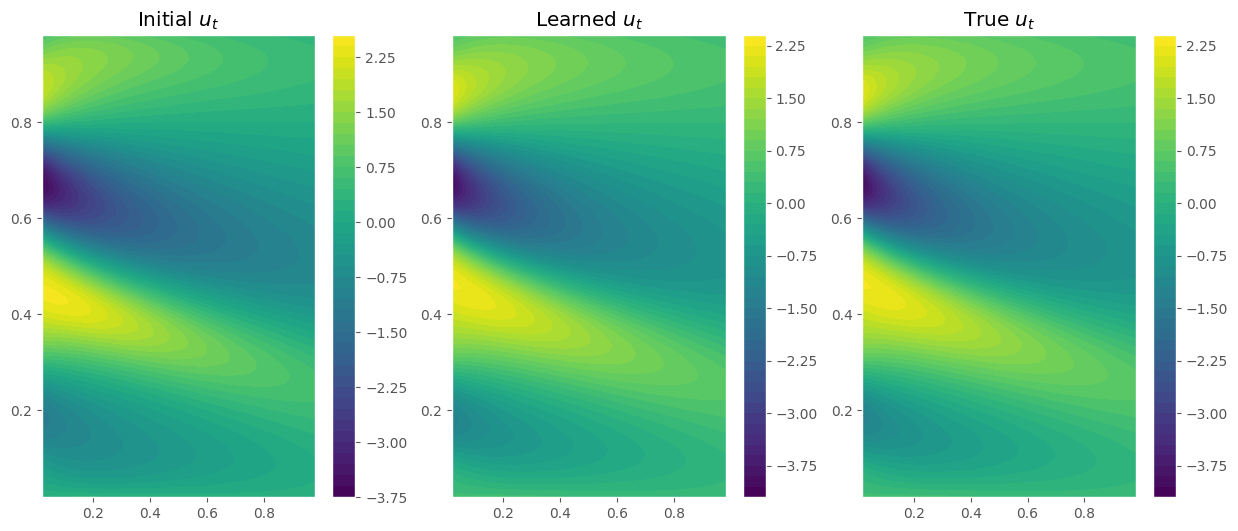

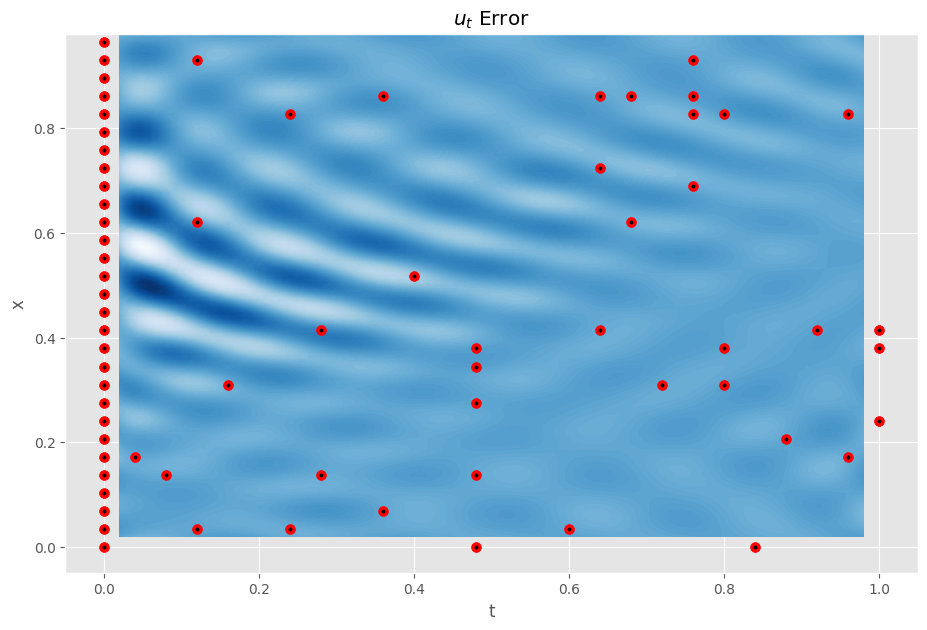

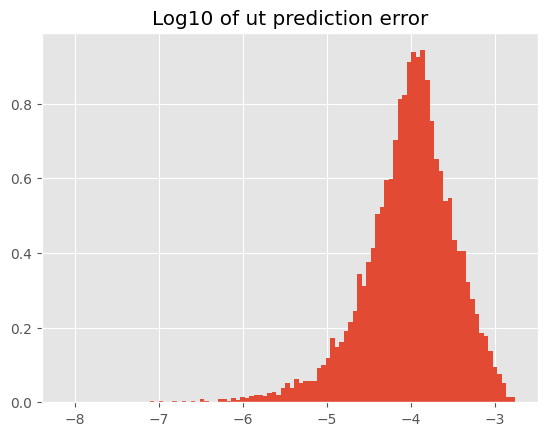

In [13]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)

plt.title("Initial $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],P_preds_init_model_features,50)
plt.colorbar()

plt.subplot(1,3,2)
plt.title("Learned $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],preds_ut_model_features,50,)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("True $u_t$")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true,50)
plt.colorbar()

plt.show()
plt.figure(figsize=(11,7))
plt.title("$u_t$ Error")
plt.tricontourf(tx_fine_int[:,0],tx_fine_int[:,1],ut_true-preds_ut_model_features,100,cmap = 'Blues')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='red',s = 50,label = 'Given value of u(t,x)')
plt.scatter(tx_obs[:,0],tx_obs[:,1],c='black',s = 5,label = 'Given value of u(t,x)')

#plt.scatter(tx_all[:,0],tx_all[:,1],c='black',s = 4)
plt.xlabel("t")
plt.ylabel("x")
plt.show()
plt.title("Log10 of ut prediction error")
plt.hist(jnp.log10(jnp.abs(ut_true-preds_ut_model_features) + 1e-20),100,density = True)
plt.show()